# Imports

## Library Imports 

In [115]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
import glob 
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from pmdarima import auto_arima 
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## File Imports

To use this notebook, download the files from https://nswtollroaddata.com under "Data Downloads" for "M1 Eastern Distibutor (ED)." Select the years 2016, 2017, 2018, 2019, 2020 separately and download each of the CSVs separately. Put them all in a folder and DO NOT include this folder name in user_directory.

In [116]:
#get user directory
user_directory = None

In [117]:
# function to get all of the files
def get_all_dataframes(path_to_data_folder):
    # give the path and this function will return all of the dataframes in a sorted list 
    original_data = glob.glob(path_to_data_folder + "/*/*.csv",recursive=True)
    test_dataframe_list = []
    training_dataframe_list = []
    for item in original_data:
        with open(item) as f:
            df = pd.read_csv(f, parse_dates=[['Date', 'IntervalStart']], index_col = 'Date_IntervalStart')
            if "2020" in str(f):
                test_dataframe_list.append(df)
            else:
                training_dataframe_list.append(df)
    return test_dataframe_list, training_dataframe_list

In [118]:
# import files 
if user_directory != None:    #i.e.: use the directory given
    test_df_list, train_df_list = get_all_dataframes(user_directory)
else:    # point to my directory
    test_df_list, train_df_list = get_all_dataframes("./eastern_distrib")

In [119]:
train_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2015-12-01,ED,201602,00:14,1,Car,C,N,William Street North-bound exit ramp,-33.875924,151.217253,Ramp Gantry,6
2015-12-01,ED,201602,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,19


In [120]:
test_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2019-12-01,ED,202002,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,161
2019-12-01,ED,202002,00:14,1,Truck,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,2


# Cleaning the Dataframe

In [121]:
# function to clean the dataframe list 
def clean_dfs(dataframe_list):
    clean_dataframe_list = []
    for df in dataframe_list:
        df_C = df[df['TollPointID'] == 'C']
        df_grouped = pd.DataFrame(df_C.groupby('Date_IntervalStart').TotalVolume.sum())
        clean_dataframe_list.append(df_grouped)
    return clean_dataframe_list

In [122]:
# training dataframes
clean_train_df_list = clean_dfs(train_df_list)
# test dataframes
clean_test_df_list = clean_dfs(test_df_list)

In [123]:
clean_train_df_list[0].head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


## Combing the list dataframes into one dataframe 

In [124]:
train_df = pd.concat(clean_df_list)
test_df = pd.concat(clean_test_df_list)

In [125]:
train_df.head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


# Adding Features to the dataframe 

## Adding day of week feature to each dataframe 

Do I need to do all of these to the test df too?

train_df['day_of_week'] = train_df.index.dayofweek
test_df['day_of_week'] = test_df.index.dayofweek

## Resample

train_df['TotalVolumetime_shift'] = train_df['TotalVolume'] - train_df.TotalVolume.shift((7*24))

In [126]:
# resampling days in a new dataframe
train_df_days = train_df.resample('d').sum()

In [127]:
train_df_days

,TotalVolume
Date_IntervalStart,
2015-07-01,12645
2015-07-02,13138
2015-07-03,13692
2015-07-04,10937
2015-07-05,8486
...,...
2019-06-26,14327
2019-06-27,15197
2019-06-28,16217


In [128]:
# resampling to the hour in the train dataframe
train_df = train_df.resample('H').sum()

In [129]:
train_df.head()

,TotalVolume
Date_IntervalStart,
2015-07-01 00:00:00,19
2015-07-01 01:00:00,16
2015-07-01 02:00:00,11
2015-07-01 03:00:00,12
2015-07-01 04:00:00,40


In [205]:
# resampling to the hour in the test dataframe
test_df = test_df.resample('H').sum()

In [207]:
test_df.head(2)

,TotalVolume,ShiftWeek,DiffWeek,hour,isBusinessHour
Date_IntervalStart,,,,,
2019-07-01 00:00:00,29,541.0,-512.0,0,0
2019-07-01 01:00:00,15,1125.0,-1110.0,4,0


## Time shifting the Training dataframe

In [130]:
train_df['week_diff'] = train_df['TotalVolume'] - train_df.TotalVolume.shift((7*24))

train_df['year_diff'] = train_df['TotalVolume'] - train_df.TotalVolume.shift((365*24))

train_df['year_and_week_diff'] = train_df['year_diff'] - train_df['week_diff'] 

train_df['week_and_2month_diff'] = train_df['TotalVolume'] - train_df.TotalVolume.shift((30*2*24))  

In [131]:
train_df.head(2)

,TotalVolume,week_diff
Date_IntervalStart,,
2015-07-01 00:00:00,19,NaN
2015-07-01 01:00:00,16,NaN


## Dropping nan rows from week_diff 

In [152]:
train_df.dropna(inplace=True)

In [153]:
train_df.head()

,TotalVolume,week_diff,ShiftDay,ShiftWeek,DiffWeek,hour,isBusinessHour
Date_IntervalStart,,,,,,,
2015-07-08 00:00:00,25,6.0,26.0,19.0,6.0,0,0
2015-07-08 01:00:00,16,0.0,7.0,16.0,0.0,1,0
2015-07-08 02:00:00,13,2.0,13.0,11.0,2.0,2,0
2015-07-08 03:00:00,15,3.0,11.0,12.0,3.0,3,0
2015-07-08 04:00:00,48,8.0,35.0,40.0,8.0,4,0


# Methods

## isBusiness

In [154]:
def isBusiness(x, morning=6, evening=19):
    if x in range(morning, evening):
        return 1
    else:
        return 0

## stationarity_check

In [155]:
from statsmodels.tsa.stattools import adfuller
def stationarity_check(TS, window = 364 * 4, column = 'TotalVolume'):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    #plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

## test_stationarity

In [156]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

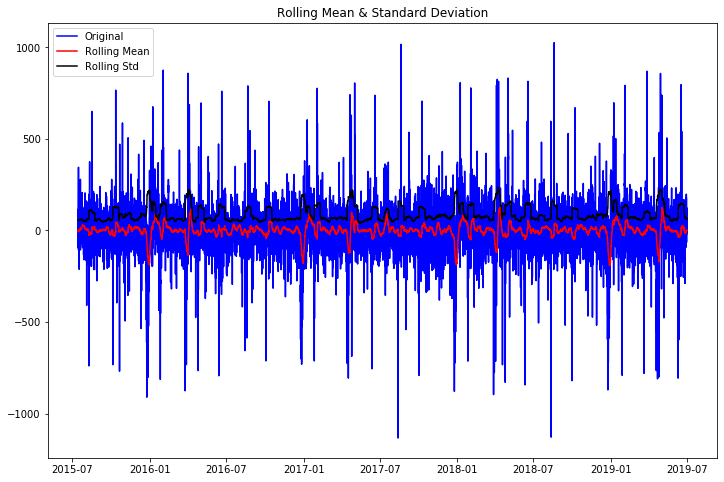

Results of Dickey-Fuller Test:
Test Statistic                -1.514189e+01
p-value                        6.991816e-28
#Lags Used                     4.900000e+01
Number of Observations Used    3.484600e+04
Critical Value (1%)           -3.430538e+00
Critical Value (5%)           -2.861623e+00
Critical Value (10%)          -2.566814e+00
dtype: float64


In [157]:
test_stationarity(train_df['week_diff'], window=168)

With the p value less than the critical value of 0.05, we can conclude that the data is very likely to be stationary.

# Shifts

In [158]:
train_df['ShiftDay'] = train_df['TotalVolume'].shift(periods=24)
train_df['ShiftWeek'] = train_df['TotalVolume'].shift(periods=7*24)

In [159]:
train_df.head(50)

,TotalVolume,week_diff,ShiftDay,ShiftWeek,DiffWeek,hour,isBusinessHour
Date_IntervalStart,,,,,,,
2015-07-08 00:00:00,25,6.0,NaN,NaN,6.0,0,0
2015-07-08 01:00:00,16,0.0,NaN,NaN,0.0,1,0
2015-07-08 02:00:00,13,2.0,NaN,NaN,2.0,2,0
2015-07-08 03:00:00,15,3.0,NaN,NaN,3.0,3,0
2015-07-08 04:00:00,48,8.0,NaN,NaN,8.0,4,0
2015-07-08 05:00:00,185,-9.0,NaN,NaN,-9.0,5,0
2015-07-08 06:00:00,816,38.0,NaN,NaN,38.0,6,1
2015-07-08 07:00:00,955,-69.0,NaN,NaN,-69.0,7,1
2015-07-08 08:00:00,1002,-9.0,NaN,NaN,-9.0,8,1


In [160]:
train_df['DiffWeek'] = train_df['TotalVolume'] - train_df['ShiftWeek']

In [161]:
test_df['ShiftWeek'] = test_df['TotalVolume'].shift(periods=7*24)

In [162]:
test_df['DiffWeek'] = test_df['TotalVolume'] - test_df['ShiftWeek']

test_df.TotalVolume.index[0], test_df['ShiftWeek'].dropna().index[0]

(Timestamp('2019-12-01 00:00:00'), Timestamp('2019-12-02 18:00:00'))

In [163]:
test_df['ShiftWeek'].dropna().index[0] #2019-07-08 00:00:00

Timestamp('2019-12-02 18:00:00')

In [164]:
train_df['hour'] = train_df.index.hour
test_df['hour'] = test_df.index.hour

In [165]:
train_df['isBusinessHour'] = train_df['hour'].apply(isBusiness)
test_df['isBusinessHour'] = test_df['hour'].apply(isBusiness)

In [166]:
train_df.head(24)

,TotalVolume,week_diff,ShiftDay,ShiftWeek,DiffWeek,hour,isBusinessHour
Date_IntervalStart,,,,,,,
2015-07-08 00:00:00,25,6.0,NaN,NaN,NaN,0,0
2015-07-08 01:00:00,16,0.0,NaN,NaN,NaN,1,0
2015-07-08 02:00:00,13,2.0,NaN,NaN,NaN,2,0
2015-07-08 03:00:00,15,3.0,NaN,NaN,NaN,3,0
2015-07-08 04:00:00,48,8.0,NaN,NaN,NaN,4,0
2015-07-08 05:00:00,185,-9.0,NaN,NaN,NaN,5,0
2015-07-08 06:00:00,816,38.0,NaN,NaN,NaN,6,1
2015-07-08 07:00:00,955,-69.0,NaN,NaN,NaN,7,1
2015-07-08 08:00:00,1002,-9.0,NaN,NaN,NaN,8,1


# Correlation

## Auto Correlation

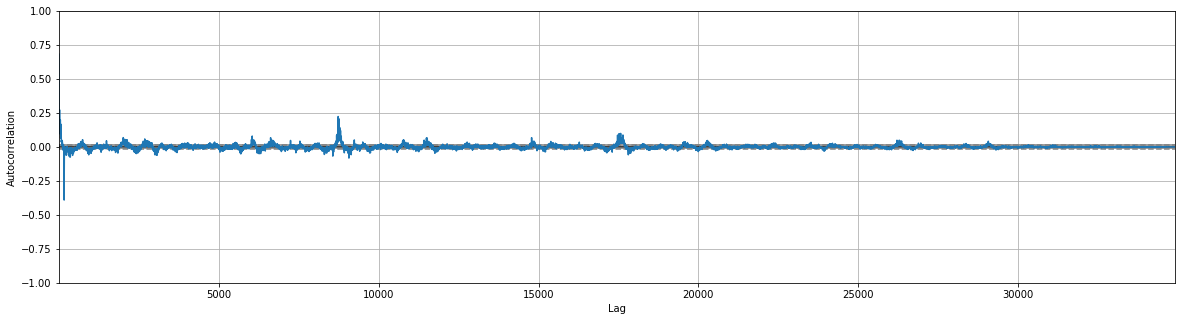

In [167]:
pd.plotting.autocorrelation_plot(train_df['week_diff'])

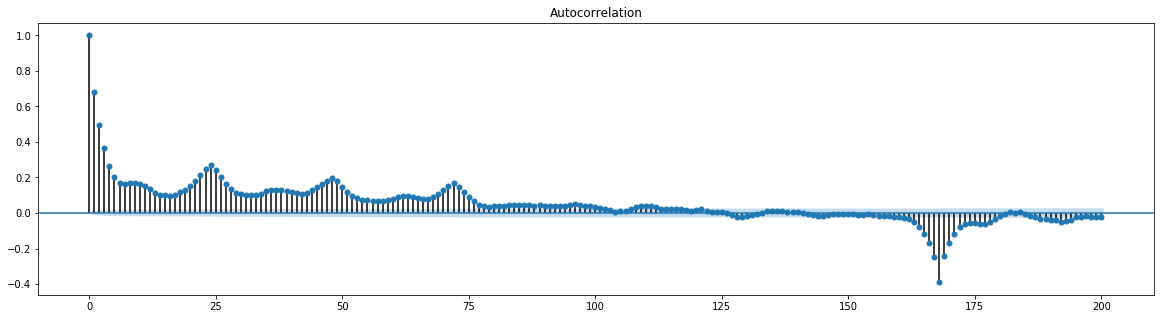

In [176]:
plot_acf(train_df['week_diff'], lags=200);

## Partial Correlation

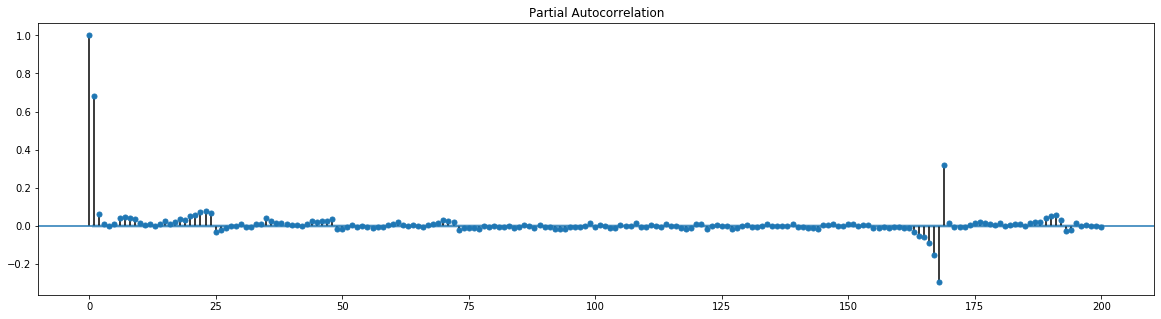

In [175]:
plot_pacf(train_df['week_diff'], lags=200);

# Models

## AR

### TotalVolume

In [178]:
m = AR(train_df['TotalVolume'])
mnolag = m.fit(method='mle', ic='aic')

In [208]:
start = test_df.index[0]
end = test_df.index[-1]

In [209]:
predmnolag = mnolag.predict(start=start, end=end, dynamic=False).rename('nolag')

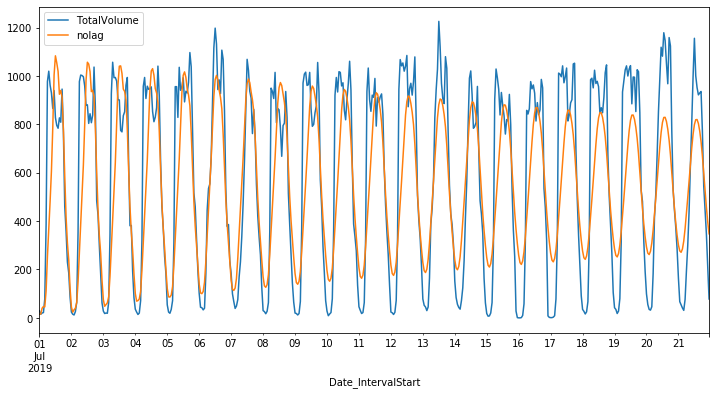

In [210]:
test_df['TotalVolume'].iloc[:24 * 21].plot(legend=True)
predmnolag.iloc[:24 * 21].plot(legend=True, figsize=(12,6));

## ARMA

### order = (7,1)

In [181]:
mod_arma = ARMA(df['TotalVolume'], order=(7,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:            TotalVolume   No. Observations:                34896
Model:                     ARMA(7, 1)   Log Likelihood             -217240.610
Method:                       css-mle   S.D. of innovations            122.289
Date:                Thu, 26 Mar 2020   AIC                         434501.220
Time:                        15:14:34   BIC                         434585.821
Sample:                    07-08-2015   HQIC                        434528.172
                         - 06-30-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               549.0492      1.640    334.799      0.000     545.835     552.263
ar.L1.TotalVolume     2.0577      0.007    288.040      0.000       2.044       2.072
ar.L2.TotalVolume    -1.

In [182]:
start = train_df.index[-1]
end = test_df.index[-1]
preds = res_arma.predict(start=start, end=end, dynamic=False)

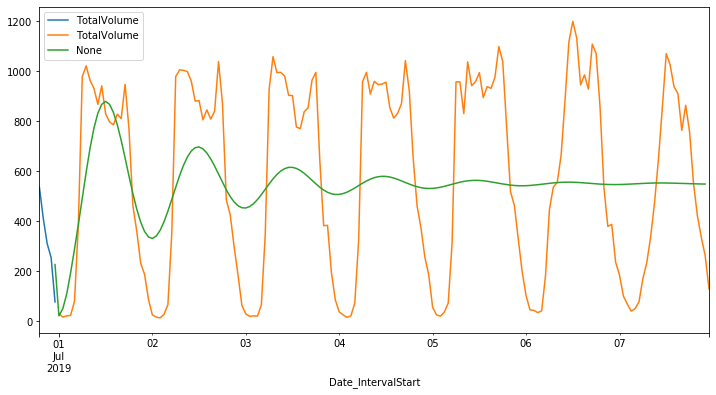

In [189]:
# Plot the results
preds.rename('Forecast')
train_df['TotalVolume'].iloc[-5:].plot(legend=True)
train_df['TotalVolume'].iloc[:24 * 7].plot(legend=True)
preds.iloc[:24 * 7].plot(legend=True,figsize=(12,6));

## ARIMA

In [131]:
from statsmodels.tsa.arima_model import ARIMA

mod_arima = ARIMA(train_df['TotalVolume'], order=(24, 1, 0))
mod_arima_fit = mod_arima.fit(method='mle')

# Print out summary information on the fit
print(mod_arima_fit.summary())

# Print out the estimate for the constant and for theta
print(mod_arima_fit.params)

KeyboardInterrupt: 

In [ ]:
start = test_df.index[0]
end = test_df.index[-1]
preds = mod_arima_fit.predict(start=start, end=end, dynamic=False)

In [ ]:
preds_sarimax = mod_sarimax_fit.predict(start=start, end=end, dynamic=False, typ='levels')
preds_sarimax.rename('SARIMAX predictions')
train_df['TotalVolume'].iloc[-5:].plot(legend=True)
test_df['TotalVolume'].iloc[:24 * 7].plot(legend=True)
preds_sarimax.iloc[:24 * 7].plot(legend=True,figsize=(12,6));

### arima with exog

In [ ]:
marimae = ARIMA(train_df['TotalVolume'], order=(2,1,2))
marimae_fit = marimae.fit(method='mle')

## SARIMAX

In [214]:
mod_sarimax = sm.tsa.statespace.SARIMAX(train_df['TotalVolume'],
                                order=(2, 1, 2))#,
                                #seasonal_order=(1, 0, 1, 24 * 7),
                                #enforce_stationarity=False,
                                #enforce_invertibility=False)
mod_sarimax_fit = mod_sarimax.fit()
print(mod_sarimax_fit.summary())

                           Statespace Model Results                           
Dep. Variable:            TotalVolume   No. Observations:                34896
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -218064.010
Date:                Thu, 26 Mar 2020   AIC                         436138.019
Time:                        16:04:05   BIC                         436180.320
Sample:                    07-08-2015   HQIC                        436151.495
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8857      0.002    855.567      0.000       1.881       1.890
ar.L2         -0.9562      0.002   -430.254      0.000      -0.961      -0.952
ma.L1         -1.9257      0.002   -911.264      0.0

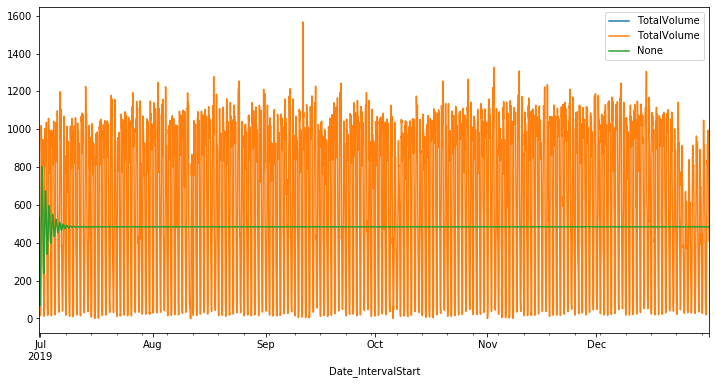

In [216]:
preds_sarimax = mod_sarimax_fit.predict(start=start, end=end, dynamic=False, typ='levels')
preds_sarimax.rename('SARIMAX predictions')
train_df['TotalVolume'].iloc[-5:].plot(legend=True)
test_df['TotalVolume'].iloc[:24 * 7].plot(legend=True)
preds_sarimax.iloc[:24 * 7].plot(legend=True,figsize=(12,6));

In [224]:
mod_sarimax_seasonal = sm.tsa.statespace.SARIMAX(train_df['TotalVolume'],
                                order=(2, 1, 2),
                                seasonal_order=(2,1,2, 24 * 7),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
mod_sarimax_seasonal_fit = mod_sarimax.fit()
print(mod_sarimax_seasonal_fit.summary())

                           Statespace Model Results                           
Dep. Variable:            TotalVolume   No. Observations:                34896
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -218064.010
Date:                Thu, 26 Mar 2020   AIC                         436138.019
Time:                        16:08:39   BIC                         436180.320
Sample:                    07-08-2015   HQIC                        436151.495
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8857      0.002    855.567      0.000       1.881       1.890
ar.L2         -0.9562      0.002   -430.254      0.000      -0.961      -0.952
ma.L1         -1.9257      0.002   -911.264      0.0

#### SARIMAX order from day

In [462]:
mdsarimax_day_params = sm.tsa.statespace.SARIMAX(train_df['TotalVolume'], 
                                                order=(2,1,2),
                                                seasonal_order=(1, 0, 1, 7),
                                                exog=train_df['isBusinessHour']
                                                )
mshdp = mdsarimax_day_params.fit()
print(mshdp.summary())

                                 Statespace Model Results                                
Dep. Variable:                       TotalVolume   No. Observations:                34896
Model:             SARIMAX(2, 1, 2)x(1, 0, 1, 7)   Log Likelihood             -214344.346
Date:                           Thu, 26 Mar 2020   AIC                         428704.693
Time:                                   21:40:28   BIC                         428772.374
Sample:                               07-08-2015   HQIC                        428726.254
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
isBusinessHour   345.4213      1.506    229.298      0.000     342.469     348.374
ar.L1              0.7282      

### SARIMA with exogenous variable

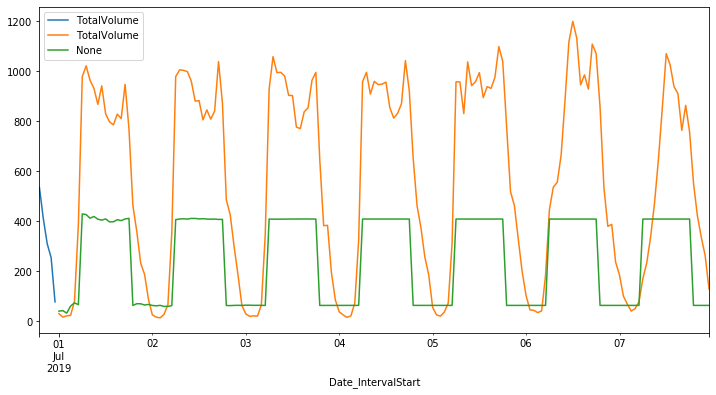

In [463]:
df_test_hour_shaped = np.array(df_test['isBusinessHour']).reshape(4416,1)
preds_mshdp = mshdp.predict(start=start, end=end, dynamic=False, typ='levels', exog=df_test_hour_shaped)
preds_mshdp.rename('SARIMAX 212 X 1017')
train_df['TotalVolume'].iloc[-5:].plot(legend=True)
test_df['TotalVolume'].iloc[:24 * 7].plot(legend=True)
preds_mshdp.iloc[:24 * 7].plot(legend=True,figsize=(12,6));

In [464]:
mdsarimax_day_params1 = sm.tsa.statespace.SARIMAX(train_df['TotalVolume'], 
                                                order=(2,1,2),
                                                exog=train_df['isBusinessHour']
                                                )
mshdp1 = mdsarimax_day_params1.fit()
print(mshdp1.summary())

                           Statespace Model Results                           
Dep. Variable:            TotalVolume   No. Observations:                34896
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -211120.231
Date:                Thu, 26 Mar 2020   AIC                         422252.462
Time:                        21:48:57   BIC                         422303.223
Sample:                    07-08-2015   HQIC                        422268.633
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
isBusinessHour   264.1475      1.566    168.647      0.000     261.078     267.217
ar.L1              1.8699      0.002    763.003      0.000       1.865       1.875
ar.L2             -0.9418      0.002

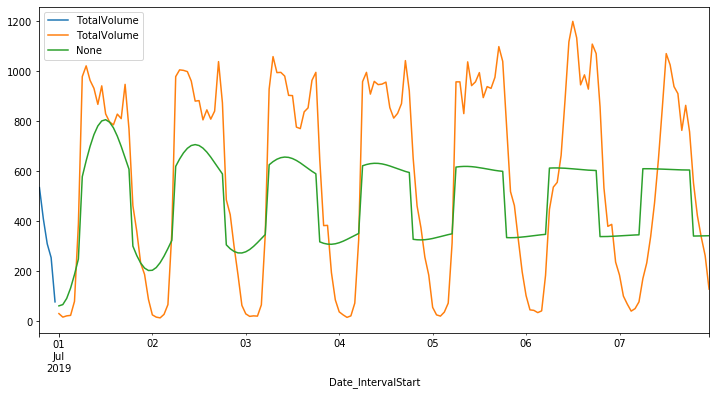

In [465]:
df_test_hour_shaped = np.array(test_df['isBusinessHour']).reshape(4416,1)
preds_mshdp1 = mshdp1.predict(start=start, end=end, dynamic=False, typ='levels', exog=df_test_hour_shaped)
preds_mshdp1.rename('SARIMAX 212 X 1017')
df['TotalVolume'].iloc[-5:].plot(legend=True)
df_test['TotalVolume'].iloc[:24 * 7].plot(legend=True)
preds_mshdp1.iloc[:24 * 7].plot(legend=True,figsize=(12,6));

In [471]:
#SARIMAX(3, 1, 3)x(0, 0, 1, 7)
mdsarimax_day_params2 = sm.tsa.statespace.SARIMAX(train_df['TotalVolume'], 
                                                order=(3,1,3),
                                                seasonal_order=(0,0,1,7),
                                                exog=train_df['isBusinessHour']
                                                )
mshdp2 = mdsarimax_day_params2.fit()
print(mshdp2.summary())

                                 Statespace Model Results                                
Dep. Variable:                       TotalVolume   No. Observations:                34896
Model:             SARIMAX(3, 1, 3)x(0, 0, 1, 7)   Log Likelihood             -210712.986
Date:                           Thu, 26 Mar 2020   AIC                         421443.972
Time:                                   22:24:33   BIC                         421520.112
Sample:                               07-08-2015   HQIC                        421468.228
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
isBusinessHour   351.2125      1.874    187.445      0.000     347.540     354.885
ar.L1              0.8549      

Isn't the cell the same as the other model? I can't see how they are different thought the graphs are different

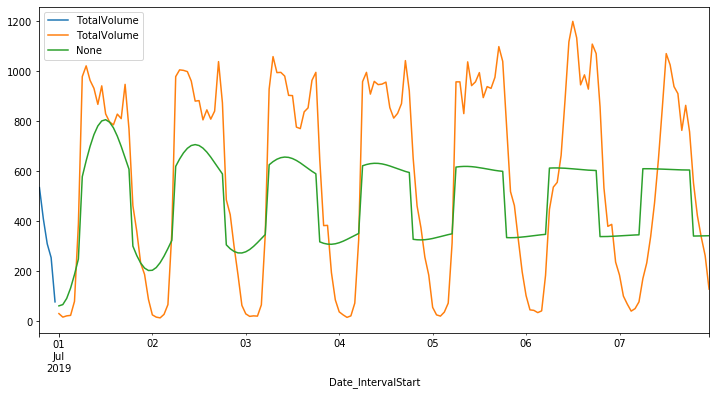

In [472]:
df_test_hour_shaped = np.array(df_test['isBusinessHour']).reshape(4416,1)
preds_mshdp2 = mshdp2.predict(start=start, end=end, dynamic=False, typ='levels', exog=df_test_hour_shaped)
preds_mshdp2.rename('SARIMAX 313 X 0017 w Exog')
df['TotalVolume'].iloc[-5:].plot(legend=True)
df_test['TotalVolume'].iloc[:24 * 7].plot(legend=True)
preds_mshdp1.iloc[:24 * 7].plot(legend=True,figsize=(12,6));

# Auto-Arima

In [243]:
#8736 hours in a year
auto = auto_arima(train_df['TotalVolume'].iloc[8736:],seasonal=False,m=168).summary()

In [213]:
auto

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                34896
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -218064.604
Date:                Thu, 26 Mar 2020   AIC                         436141.208
Time:                        16:00:53   BIC                         436191.968
Sample:                             0   HQIC                        436157.379
                              - 34896                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0028      0.010     -0.279      0.780      -0.022       0.017
ar.L1          1.8852      0.003    751.931      0.000       1.880       1.890
ar.L2         -0.9556      0.003   -378.379      0.000      -0.961      -0.951
ma.L1         -1.9255      0.002   -913.388      0.000      -1.930      -1.921
ma.L2          0.9364      0.002    446.680      0.000       0.932       0.941
sigma2      1.557e+04    107.393    144.984      0.000    1.54e+04    1.58e+04
===================================================================================
Ljung-Box (Q):                    29164.16   Jarque-Bera (JB):             27151.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [382]:
auto_day = auto_arima(train_df_days['TotalVolume'],seasonal=True,m=7)

In [383]:
auto_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1454
Model:             SARIMAX(2, 1, 2)x(1, 0, 1, 7)   Log Likelihood              -12111.396
Date:                           Thu, 26 Mar 2020   AIC                          24238.791
Time:                                   20:42:20   BIC                          24281.042
Sample:                                        0   HQIC                         24254.557
                                          - 1454                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0049      0.009      0.525      0.600      -0.014       0.023
ar.L1         -0.7710      0.057    -13.593      0.000      -0.882      -0.660
ar.L2          0.2289      0.049      4.653      0.000       0.132       0.325
ma.L1          0.2722      0.056      4.891      0.000       0.163       0.381
ma.L2         -0.7273      0.051    -14.210      0.000      -0.828      -0.627
ar.S.L7        1.0000   4.23e-05   2.37e+04      0.000       1.000       1.000
ma.S.L7       -0.9914      0.006   -172.085      0.000      -1.003      -0.980
sigma2      1.422e+06   1.44e-07   9.89e+12      0.000    1.42e+06    1.42e+06
===================================================================================
Ljung-Box (Q):                      115.26   Jarque-Bera (JB):             18150.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -2.74
Prob(H) (two-sided):                  0.38   Kurtosis:                        19.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+27. Standard errors may be unstable.
"""

In [467]:
train_df.shape

(34896, 12)

In [468]:
exg = np.array(train_df['isBusinessHour']).reshape(train_df.shape[0],1)
autoexog = auto_arima(train_df['TotalVolume'], seasonal=True, m=7, exogenous=exg)

In [469]:
autoexog.summary() #SARIMAX(3, 1, 3)x(0, 0, 1, 7)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                34896
Model:             SARIMAX(3, 1, 3)x(0, 0, 1, 7)   Log Likelihood             -210734.985
Date:                           Thu, 26 Mar 2020   AIC                         421489.971
Time:                                   22:21:02   BIC                         421574.572
Sample:                                        0   HQIC                        421516.922
                                         - 34896                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0420      0.015     -2.839      0.005      -0.071      -0.013
x1           351.3244      1.966    178.713      0.000     347.471     355.177
ar.L1          0.8579      0.003    287.436      0.000       0.852       0.864
ar.L2          0.9293      0.001   1107.814      0.000       0.928       0.931
ar.L3         -0.9281      0.003   -309.747      0.000      -0.934      -0.922
ma.L1         -0.9039      0.003   -308.291      0.000      -0.910      -0.898
ma.L2         -0.9864      0.001   -887.750      0.000      -0.989      -0.984
ma.L3          0.9120      0.003    310.830      0.000       0.906       0.918
ma.S.L7       -0.0142      0.007     -1.984      0.047      -0.028      -0.000
sigma2      1.153e+04     80.253    143.708      0.000    1.14e+04    1.17e+04
===================================================================================
Ljung-Box (Q):                    20601.24   Jarque-Bera (JB):              4018.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# RMSE Comparison

In [209]:
predmnolag.iloc[1:]

2019-07-01 00:00:00     15.177725
2019-07-01 01:00:00     16.016650
2019-07-01 02:00:00     40.191866
2019-07-01 03:00:00     46.910572
2019-07-01 04:00:00     45.444644
                          ...    
2019-12-31 19:00:00    548.901157
2019-12-31 20:00:00    548.603246
2019-12-31 21:00:00    548.324111
2019-12-31 22:00:00    548.082704
2019-12-31 23:00:00    547.895351
Freq: H, Name: nolag, Length: 4416, dtype: float64

In [206]:
test_df['TotalVolume']

Date_IntervalStart
2019-07-01 00:00:00     29
2019-07-01 01:00:00     15
2019-07-01 02:00:00     20
2019-07-01 03:00:00     22
2019-07-01 04:00:00     78
                      ... 
2019-12-31 19:00:00    853
2019-12-31 20:00:00    691
2019-12-31 21:00:00    594
2019-12-31 22:00:00    528
2019-12-31 23:00:00    410
Name: TotalVolume, Length: 4416, dtype: int64

In [204]:
len(test_df['TotalVolume']), len(predmnolag)

(4416, 4417)

In [239]:
from sklearn.metrics import mean_squared_error

labels = ['ARnolag', 'AR','ARMA','SARIMAX', 'SARIMAX_SEASONAL', 'SARIMAX']
preds_list = [predmnolag[:24 * 21], predar1[:24 * 21], preds[:24 * 21], preds_sarimax[:24 * 21], preds_sarimax_seasonal[:24 * 21], None]  # these are variables, not strings!

for i in range(len(preds_list)):
    error = mean_squared_error(test_df['TotalVolume'].iloc[:24 * 21], preds_list[i])
    print(f'{labels[i]} Error: {error:11.10}')

ARnolag Error: 68322.47476
AR Error:   58524.534
ARMA Error: 144629.2036
SARIMAX Error: 150113.7128
SARIMAX_SEASONAL Error: 150113.7128


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [121]:
labels = ['ar1', 'arma', 'arima', 'sarimax']
modls = [AR1fit]

for i in range(len(modls)):
    print(f'{labels[i]} AIC: {modls[i].rmse:6.5}')

NameError: name 'AR2fit' is not defined

# Models By Day

## AR

In [360]:
df_days_test = df_test.resample('d').sum()

In [361]:
df_days_test

,TotalVolume,week_timeshift,DiffWeek
Date_IntervalStart,,,
2019-07-01,13324,0.0,0.0
2019-07-02,13849,0.0,0.0
2019-07-03,14121,0.0,0.0
2019-07-04,14396,0.0,0.0
2019-07-05,15327,0.0,0.0
...,...,...,...
2019-12-27,12267,16824.0,-4557.0
2019-12-28,12004,14558.0,-2554.0
2019-12-29,10151,11310.0,-1159.0


In [363]:
startd = df_days_test.index[0]
endd = df_days_test.index[-1]

In [364]:
modeldayar = AR(train_df_days['TotalVolume'])
mdaysar = modeldayar.fit(method='mle', ic='aic')
predsdaysar = mdaysar.predict(start=startd, end=endd, dynamic=False).rename('Basic AR Day')

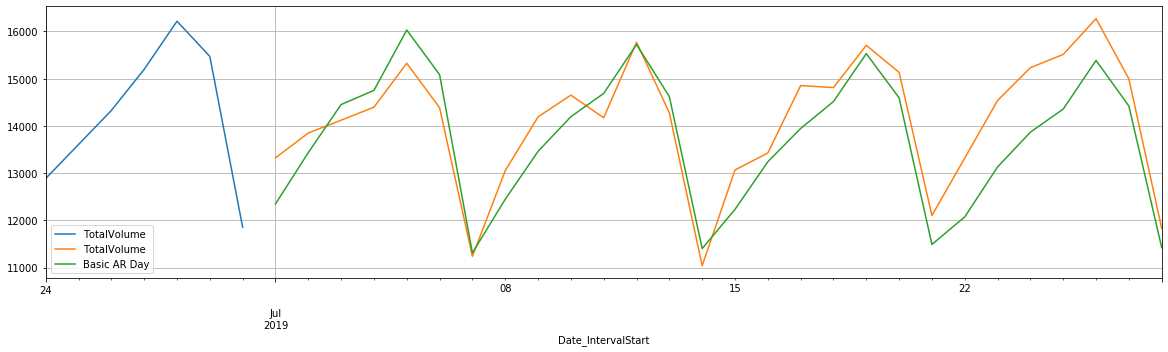

In [379]:
train_df_days['TotalVolume'].iloc[-7:].plot(legend=True)
df_days_test['TotalVolume'].iloc[:28].plot(legend=True)
predsdaysar.iloc[:28].plot(legend=True, grid=True)

## SARIMAX

In [ ]:
#SARIMAX(2, 1, 2)x(1, 0, 1, 7)


In [386]:
msarimaxdays = sm.tsa.statespace.SARIMAX(train_df_days['TotalVolume'],
                                order=(2, 1, 2),
                                seasonal_order=(1, 0, 1, 7))#,
                                #enforce_stationarity=False,
                                #enforce_invertibility=False)
mod_sarimax_days_fit = msarimaxdays.fit()
print(mod_sarimax_days_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                       TotalVolume   No. Observations:                 1454
Model:             SARIMAX(2, 1, 2)x(1, 0, 1, 7)   Log Likelihood              -12049.590
Date:                           Thu, 26 Mar 2020   AIC                          24113.181
Time:                                   20:44:49   BIC                          24150.151
Sample:                               07-08-2015   HQIC                         24126.975
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6993      0.073     -9.517      0.000      -0.843      -0.555
ar.L2          0.2997      0.032      9.275

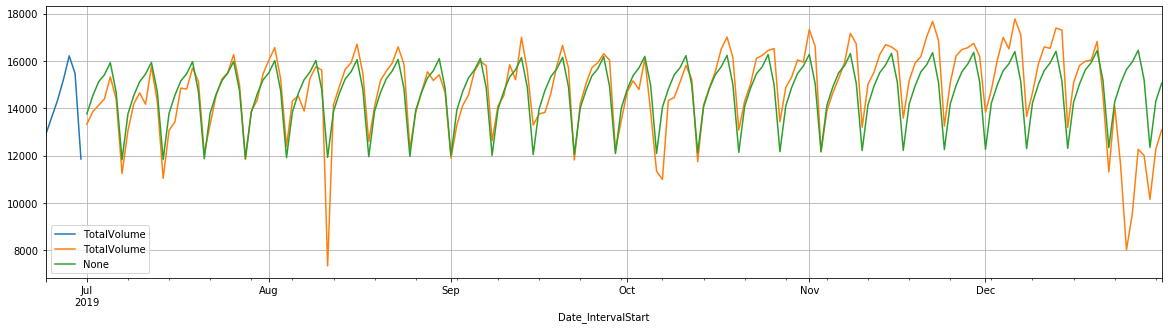

In [401]:
preds_sarimax_days = mod_sarimax_days_fit.predict(start=startd, end=endd, dynamic=False, typ='levels')
preds_sarimax_days.rename('SARIMAX predictions')
train_df_days['TotalVolume'].iloc[-7:].plot(legend=True)
df_days_test['TotalVolume'].plot(legend=True)
preds_sarimax_days.plot(legend=True,grid=True);

# RMSE DAYS Comparison

In [378]:
#average daily traffic
#mean = 13177
#std = 1979
#min = 5841
#max = 16684
train_df_days.describe()

,TotalVolumetime_shift,TotalVolume,day_of_week,week_diff,year_diff,year_and_week_diff,week_and_2month_diff,ShiftDay,ShiftWeek,DiffWeek
count,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000
mean,13165.396836,13177.392710,72.082531,11.995873,492.575653,480.215268,90.326685,13169.239340,13108.919532,12.756534
std,1981.623598,1979.781569,47.995799,1395.224819,1637.126859,1808.404049,2858.355208,2009.420816,2176.305301,1394.964656
min,5841.000000,5841.000000,0.000000,-9005.000000,-7432.000000,-7517.000000,-9220.000000,0.000000,0.000000,-9005.000000
25%,12249.500000,12258.500000,24.000000,-387.250000,0.000000,0.000000,-1734.250000,12258.500000,12212.000000,-383.000000
50%,13446.500000,13459.500000,72.000000,57.500000,254.000000,80.000000,-25.500000,13459.500000,13436.500000,53.500000
75%,14594.000000,14625.000000,120.000000,490.250000,1335.000000,1400.250000,2052.250000,14625.000000,14594.000000,490.250000
max,16684.000000,16684.000000,144.000000,7798.000000,7539.000000,8395.000000,9280.000000,16684.000000,16684.000000,7798.000000


In [402]:
#four week comparison
proj = len(df_days_test['TotalVolume'].index)
labels = ['AR', 'SARIMAX']
preds_list = [predsdaysar[:proj], preds_sarimax_days[:proj]]
for i in range(len(preds_list)):
    error = mean_squared_error(df_days_test['TotalVolume'].iloc[:proj], preds_list[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR Error: 4111716.462
SARIMAX Error: 1517624.712


In [ ]:
349613.276 <495298.0901 , 336110.7308

Over the long term, our AR model is the most accurate. However, in the short term (week time scale) our SARIMAX model is the most accurate.